In [1]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [2]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [3]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
    color_mode="grayscale",
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
    color_mode="grayscale",
)

Found 500 files belonging to 1 classes.
Using 400 files for training.


2021-11-09 20:40:00.599956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:40:00.653415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:40:00.654201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Found 500 files belonging to 1 classes.
Using 100 files for validation.


2021-11-09 20:40:00.698526: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 20:40:00.699648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:40:00.700652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:40:00.701736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

2021-11-09 20:40:01.608403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


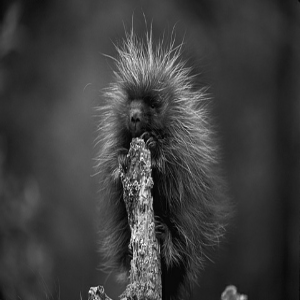

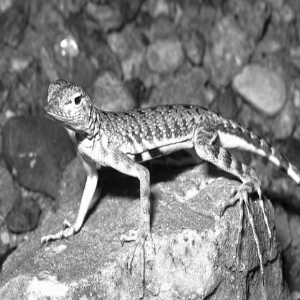

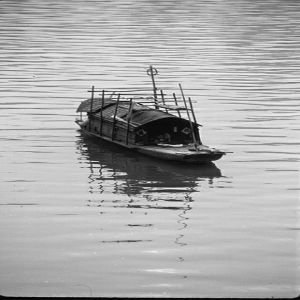

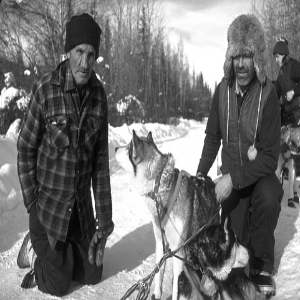

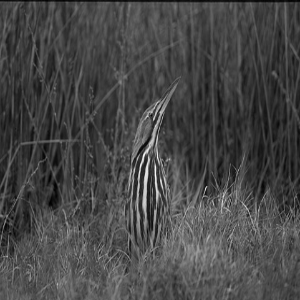

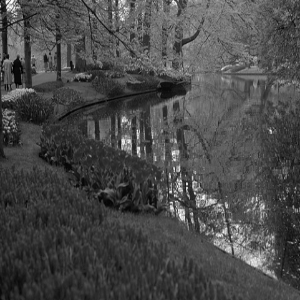

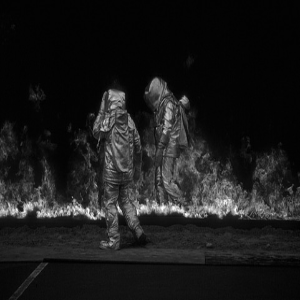

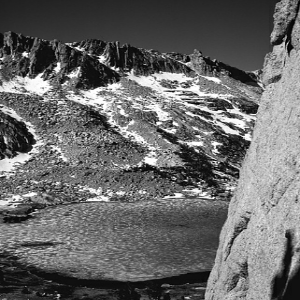

In [5]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [6]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [7]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    # input = tf.image.rgb_to_grayscale(input)
    # last_dimension_axis = len(input.shape) - 1
    # y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(input, [input_size, input_size], method="area")


def process_target(input):
    # input = tf.image.rgb_to_grayscale(input)
    # last_dimension_axis = len(input.shape) - 1
    # y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return input


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

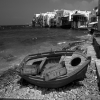

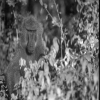

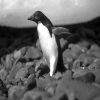

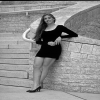

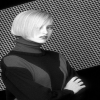

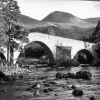

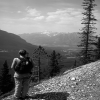

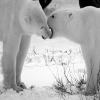

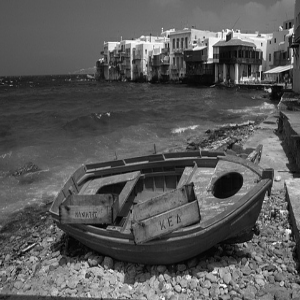

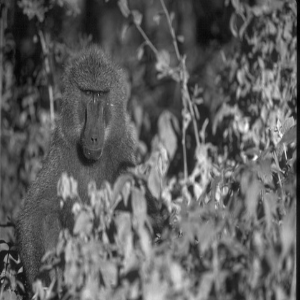

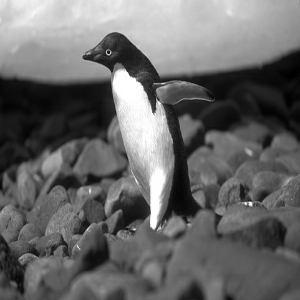

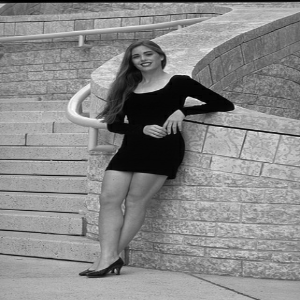

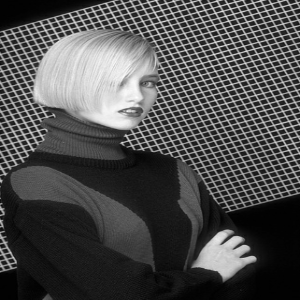

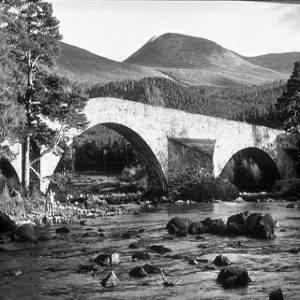

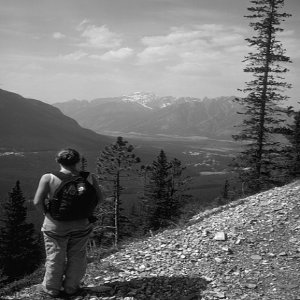

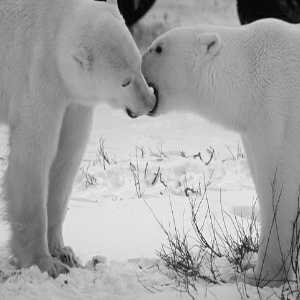

In [8]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [9]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower", cmap="gray")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower", cmap="gray")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

from scipy.fft import dct

def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    # return dct(img)
    img = img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )
    img = dct(img_to_array(img))
    img = array_to_img(img)
    return img


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [11]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [12]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

Epoch 1/100


2021-11-09 20:40:04.575243: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


50/50 - 4s - loss: 0.0322 - val_loss: 0.0059
Mean PSNR for epoch: 22.36


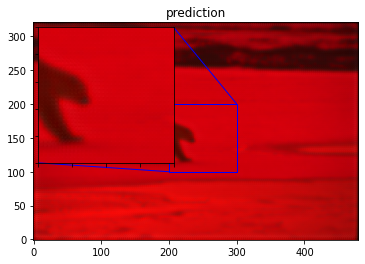

Epoch 2/100
50/50 - 1s - loss: 0.0049 - val_loss: 0.0034
Mean PSNR for epoch: 24.55
Epoch 3/100
50/50 - 1s - loss: 0.0034 - val_loss: 0.0028
Mean PSNR for epoch: 25.66
Epoch 4/100
50/50 - 1s - loss: 0.0031 - val_loss: 0.0027
Mean PSNR for epoch: 26.21
Epoch 5/100
50/50 - 1s - loss: 0.0030 - val_loss: 0.0026
Mean PSNR for epoch: 25.95
Epoch 6/100
50/50 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.19
Epoch 7/100
50/50 - 1s - loss: 0.0030 - val_loss: 0.0026
Mean PSNR for epoch: 26.15
Epoch 8/100
50/50 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.19
Epoch 9/100
50/50 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.28
Epoch 10/100
50/50 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.17
Epoch 11/100
50/50 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.25
Epoch 12/100
50/50 - 1s - loss: 0.0029 - val_loss: 0.0024
Mean PSNR for epoch: 26.00
Epoch 13/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for e

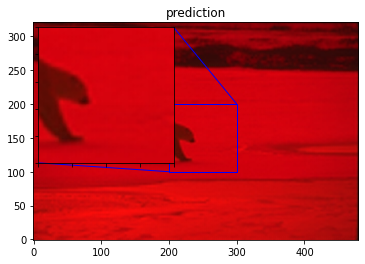

Epoch 22/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR for epoch: 26.00
Epoch 23/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.58
Epoch 24/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.61
Epoch 25/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.97
Epoch 26/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.28
Epoch 27/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 27.12
Epoch 28/100
50/50 - 1s - loss: 0.0030 - val_loss: 0.0024
Mean PSNR for epoch: 26.34
Epoch 29/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.55
Epoch 30/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.33
Epoch 31/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.09
Epoch 32/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 33/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PS

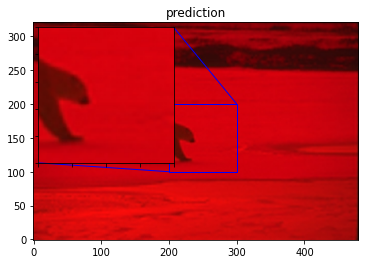

Epoch 42/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.58
Epoch 43/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.77
Epoch 44/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.80
Epoch 45/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.43
Epoch 46/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.21
Epoch 47/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.52
Epoch 48/100
50/50 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.26
Epoch 49/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.48
Epoch 50/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 51/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.61
Epoch 52/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.40
Epoch 53/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PS

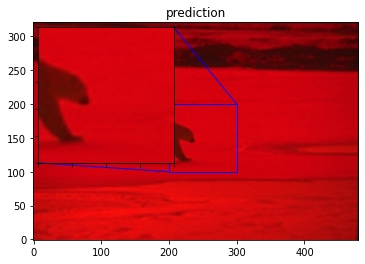

Epoch 62/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.22
Epoch 63/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.33
Epoch 64/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 27.29
Epoch 65/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.85
Epoch 66/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0029
Mean PSNR for epoch: 25.43
Epoch 67/100
50/50 - 1s - loss: 0.0030 - val_loss: 0.0023
Mean PSNR for epoch: 26.48
Epoch 68/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.65
Epoch 69/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.41
Epoch 70/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.67
Epoch 71/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.67
Epoch 72/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.84
Epoch 73/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PS

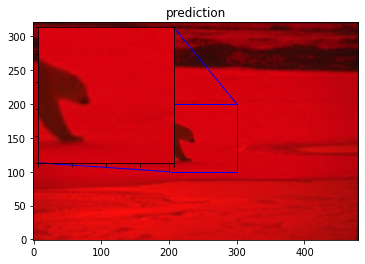

Epoch 82/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.58
Epoch 83/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.81
Epoch 84/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.65
Epoch 85/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.77
Epoch 86/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.00
Epoch 87/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.45
Epoch 88/100
50/50 - 1s - loss: 0.0026 - val_loss: 0.0028
Mean PSNR for epoch: 25.43
Epoch 89/100
50/50 - 1s - loss: 0.0030 - val_loss: 0.0023
Mean PSNR for epoch: 26.49
Epoch 90/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.34
Epoch 91/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.31
Epoch 92/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.81
Epoch 93/100
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PS

In [13]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

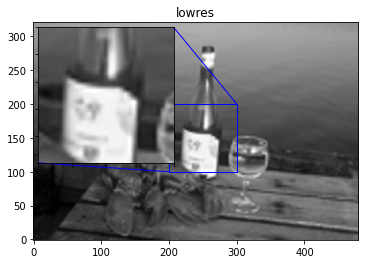

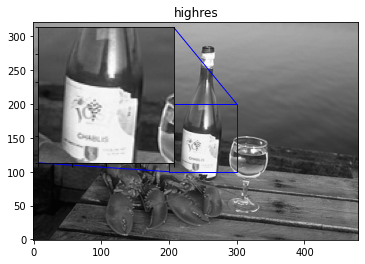

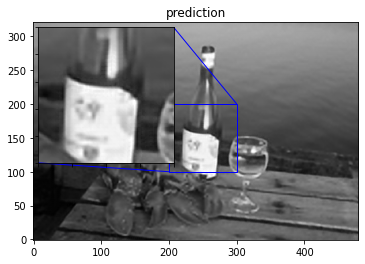

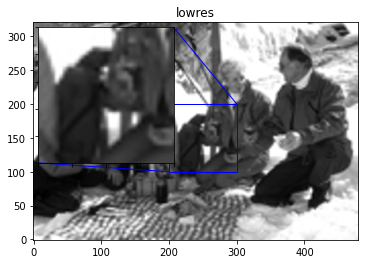

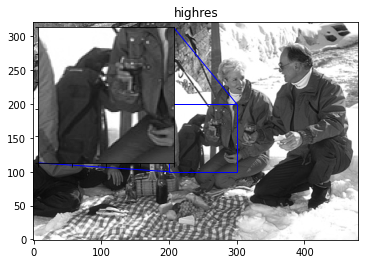

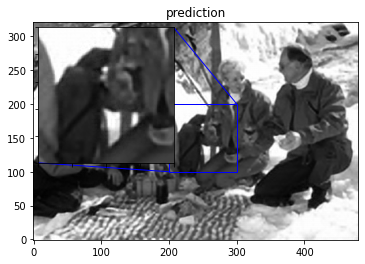

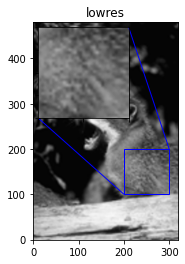

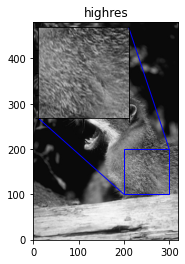

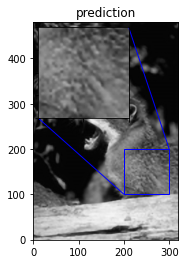

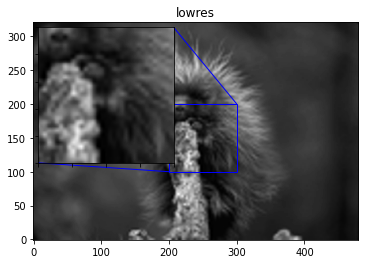

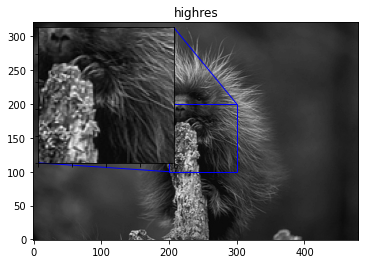

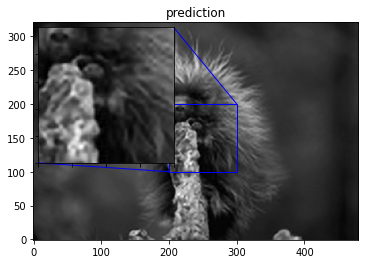

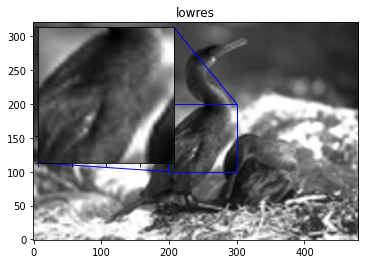

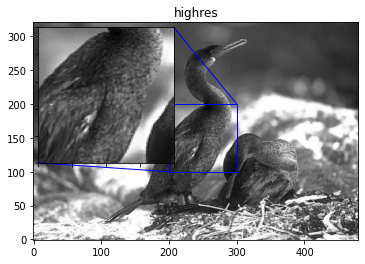

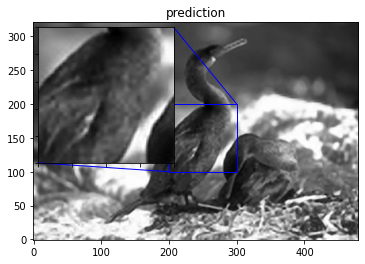

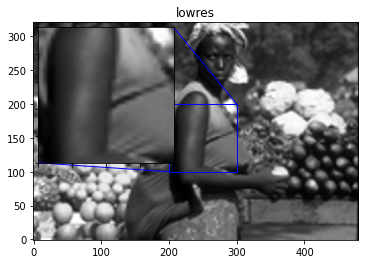

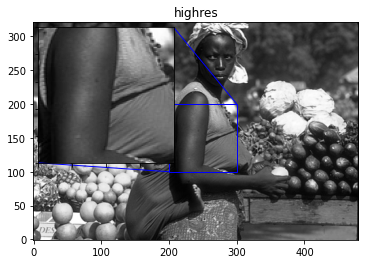

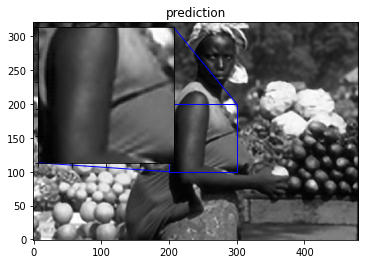

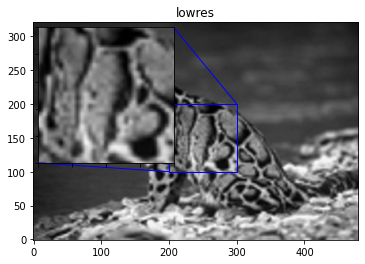

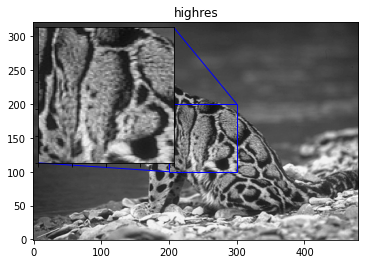

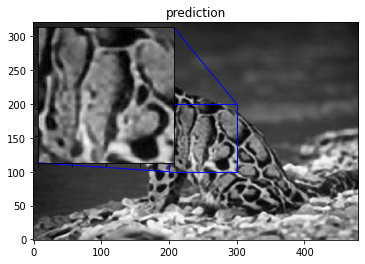

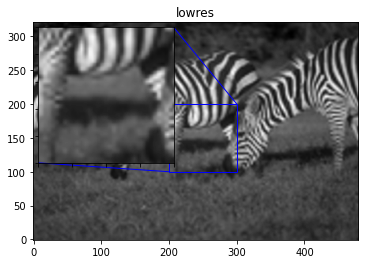

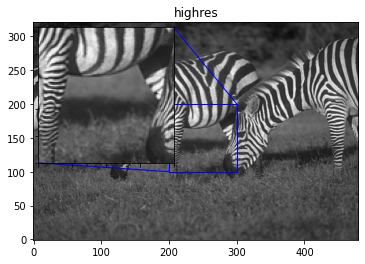

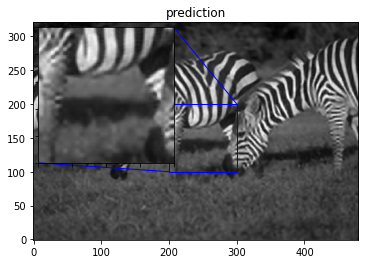

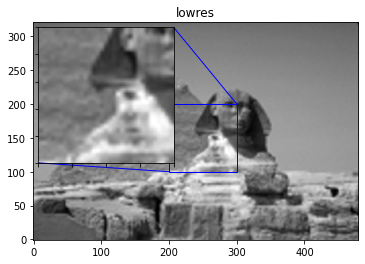

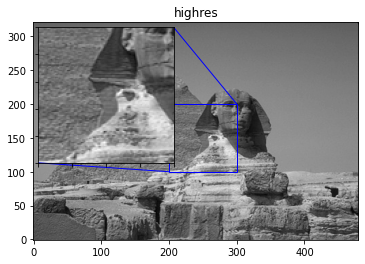

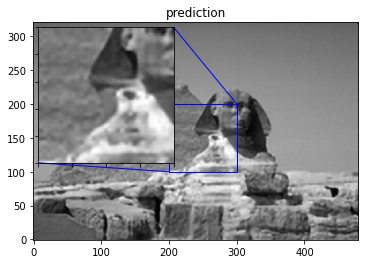

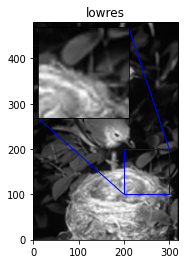

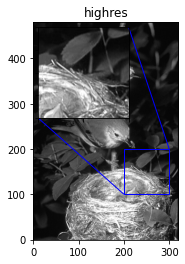

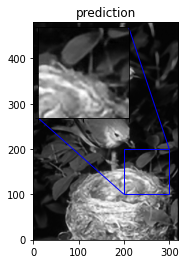

In [14]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path, color_mode="grayscale")
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    # bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    # test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    # total_bicubic_psnr += bicubic_psnr
    # total_test_psnr += test_psnr
    #
    # print(
    #     "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    # )
    # print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

# print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
# print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))